### Grid World with Q-learning Reinforcement Learning

The agent-environment interaction

The Agent uses Q-learning with initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$.

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage). The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.

##### The environment: Navigation in a gridworld


The agent has four possible actions in each state (grid square): cardinal points (NESW). The actions are unreliable. The ACTION moves the agent in the intended direction with probability 0.8, and in a random alternative direction with probability 0.2. If the direction of movement is blocked, the agent remains in the same grid square.

A reinforcement learning algorithm is used to compute the best policy for reaching the goal with as few steps as possible while avoiding the predator(s). For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for reaching the goal, and an additional $-15$ for hitting a predator. For example, the immediate reward for transitioning into the goal square is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

###### Import libraries

In [317]:
import os
from datetime import datetime, timedelta
import math

import geopandas as gpd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
import operator
from shapely.geometry import Point

###### Helper functions

###### Read in a pre-made 24 x 24 cell gameboard (centre-points of each cell)

In [318]:
game_board_gpd = gpd.read_file("GameBoard_4326_centrepoints.geojson")

In [319]:
def _board_loc(bread_crumb):
    """
    Return the lat lon point given the numpy board location
    Args:
        bread_crumb: tuple (4,2)
    Return:
        Point
    """
    game_board_id = (bread_crumb[0] +1) + (bread_crumb[1] * 24)
    pt_gpd = game_board_gpd.loc[game_board_gpd["id"] == game_board_id]
    pt = [(x,y) for x, y in zip(pt_gpd.geometry.x, pt_gpd.geometry.y)]
    return Point(pt[0])
    
# test
#print(_board_loc([(4,2), (5,5)])) 
#print(_board_loc((4,2)))

#### Create Track
- From base geojson of 24 x 24 centre-points get the location of the id that corresponds to the bread crumb
- geojson top left point is id 1, bottom right is id 576
- Bread crumb conversion example:
- bread crumb == (4, 2)
- bread crumb to id: ((4 +1) + (2 x 24)) = ID 53
- write list of crumbs to geojson with timestamp column of 1 hour interval so that Jackson can simulate movement

In [151]:
# create track
def _track(bread_crumb_list, pts_game_board_gpd):
    """
    Args:
        bread_crumb_trail: list of tuples of locations on numpy array gameboard
        pts_game_board_gpd: Geopandas dataframe of points of the game board
                            centrepoints
    Returns:
        geopandas dataframe of points of the track
        with timestamp column to simulate movement over time (1 hour increments) 
    """
    geom = [_board_loc(crumb) for crumb in bread_crumb_list]
    now = datetime.now()
    times = [(now + timedelta(hours=dt)).strftime("%Y-%m-%d-%H:%M:%S") for dt in range(len(bread_crumb_list))]
    crumb_ids = [i for i in range(len(bread_crumb_list))]
    track_gpd = gpd.GeoDataFrame({"geometry": geom, "time": times, "crumb_id": crumb_ids}, crs=4326)
    return track_gpd


# test
#test_crumbs = [(23,23), (23,22), (23,21)]
#track = _track(test_crumbs, game_board_gpd)
#print(track.head())

In [152]:
def _id_to_grid_place(grid_id, grid_size=24):
    """
    Return the numpy board location given the dataframe grid id
    e.g.: ID 53 in the geodataframe = (4,2)
    Args:
        grid_id: int, gpd grid id 
        grid_size: int, size of the numpy grid (same as gpd grid)
    Return:
        Tuple (4,2) location of gpd id on 24 x 24 numpy array
    """
    gid = grid_id - 1
    numpy_id =  (gid - (math.floor(gid / grid_size) * grid_size), math.floor((gid / grid_size))) 
    return numpy_id
    
# test
# print(_id_to_grid_place(53))
# print(_id_to_grid_place(1))
# print(_id_to_grid_place(576))

In [303]:
def _masked_array(game_board_gpd, grid_size=24):
    """
    Create a mask on the grid with value -1 for all cells that are land.
    N.B.: This doesn't return a numpy masked array, rather the cell has a -1 penalty,
          this is a flaw but serves well enough to represent the path of the smugglers
          for visualization and agent behaviour understanding.
    Args:
        game_board_gpd: GeoDataFrame of points
        grid_size: int, default 24
    Returns:
        list of tuples representing the locations of land cells
        
    """
    mask_gpd = game_board_gpd[game_board_gpd.Mask == 1]
    mask_locations = [_id_to_grid_place(gpd_id) for gpd_id in mask_gpd.id]
 
    # masked numpy array
    base_grid = np.zeros((grid_size, grid_size))
    _mask = np.zeros((grid_size, grid_size))
    for mask_loc in mask_locations:
        _mask[mask_loc[0], mask_loc[1]] = -1
    
    #masked_grid = ma.array(base_grid, mask =_mask)
    #return masked_grid[~masked_grid.mask]
    
    return _mask

#print(_masked_array(game_board_gpd, grid_size=24))

###### Game board environment: Grid World Class 

In [320]:
class GridWorld:
    ## Initialise starting data
    def __init__(self, grid_height=24, grid_width=24, pred_loc=[(2,3), (14,16)], goal_loc=(0,0), start_loc=(23,17)):
        # Set information about the gridworld
        self.height = grid_height
        self.width = grid_width
        self.grid = np.zeros(( self.height, self.width)) - 1
        self.grid = _masked_array(game_board_gpd)
        
        # Set start location
        self.current_location = start_loc
        
        # Set locations for the predators and the goal
        self.pred_location = pred_loc
        self.goal_location = goal_loc
        self.terminal_states = self.pred_location + [self.goal_location]
        
        # Set grid rewards for special cells
        for p in self.pred_location:
            self.grid[p[0], p[1]] = -15
        self.grid[ self.goal_location[0], self.goal_location[1]] = 10
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (goal or predator), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [321]:
class RandomAgent():        
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [322]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)


In [323]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    bread_crumbs_per_episode = []
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        crumbs = []
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            #crumbs.append(environment.agent_on_map())
            crumbs.append(environment.current_location)
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        bread_crumbs_per_episode.append(crumbs)
        
    return reward_per_episode, bread_crumbs_per_episode # Return performance log

#### Run Random Agent
- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [308]:
env = GridWorld(grid_height=24, grid_width=24, pred_loc=[(2,2)], goal_loc=(0,0), start_loc=(23, 17))
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (23, 17)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

#### Q-Agent
- Exeriment with the number of trials until the learning rate converges
- Performance is plotted
- Add predators to see how the agent's path changes
- Change the goal location to see how the agent's path changes

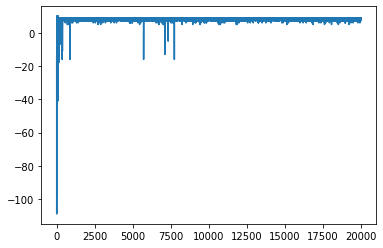

In [310]:
# GridWorld Environment
environment = GridWorld(grid_height=24, grid_width=24, pred_loc=[(2,2), (14, 16)], goal_loc=(0,0), start_loc=(23, 17))
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode, bread_crumbs_per_episode = play(environment, agentQ, trials=20000, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [244]:
# print the coordinates for the last episode
for b in bread_crumbs_per_episode[-1]:
    print(b)

(23, 18)
(23, 17)
(22, 17)
(22, 16)
(22, 15)
(23, 15)
(23, 14)
(23, 14)
(23, 13)
(23, 12)
(22, 12)
(22, 11)
(22, 10)
(21, 10)
(21, 9)
(20, 9)
(20, 8)
(20, 7)
(19, 7)
(18, 7)
(17, 7)
(16, 7)
(16, 6)
(15, 6)
(14, 6)
(13, 6)
(12, 6)
(11, 6)
(11, 5)
(11, 4)
(10, 4)
(10, 3)
(10, 2)
(9, 2)
(9, 1)
(8, 1)
(7, 1)
(6, 1)
(6, 0)
(5, 0)
(4, 0)
(3, 0)
(2, 0)
(1, 0)
(0, 0)


In [312]:
# write the last track to geojson (this one should have the best learned route)
track = _track(bread_crumbs_per_episode[-1], game_board_gpd)
test_track = "test_track.geojson"  
track.to_file(test_track, driver="GeoJSON")


##### Write a series of geojsons that represent a progression of the agent learning
- Edit the choice of trails as desired
- Default 1st, 10% increments, last

In [316]:
# write track series to geojsons
# output_dir = "path_to/rl_output_dir"

# get bread_crumb trail at 10% increments
increments = np.arange(0.1, 1, 0.1)
selected_crumbs = [round(len(bread_crumbs_per_episode)*i) for i in increments]
# add first trail to the list
selected_crumbs.append(0)
# add last trail to the list
selected_crumbs.append(len(bread_crumbs_per_episode) - 1)


for _trail in selected_crumbs:
    output_file = f"track_{_trail}.geojson"
    track = _track(bread_crumbs_per_episode[_trail], game_board_gpd)
    # output_file_path = os.path.join(output_dir, output_file) 
    track.to_file(output_file, driver="GeoJSON")

[2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 0, 19999]
